# TODO: add a column for referential or substantive controls to the base dataset and the one with embeddings

***

# Embeddings

- By [Zachary Kilhoffer](https://zkilhoffer.github.io/)
- Updated 2024-06-17

***

### Description
- This is a pipeline to create embeddings from texts using a pre-trained LLMs. 
- You can easily repeat this process with a different LLM than BERT, adding the new embeddings as new columns.
- This can be useful, for example, for a one-shot learning topic model pipeline using BERTopic for models A, B, and C (using different embeddings), then visualize and compare results as needed.

***

### Inputs
- data-clean.csv
- /fine_tuned_model/

### Outputs
- data-clean-embeddings.csv


***

In [18]:
import warnings
import pandas as pd
from transformers import BertTokenizer, BertModel, pipeline
from bertopic import BERTopic
import matplotlib.pyplot as plt
import json

# Setup

In [2]:
# display tweaks
pd.set_option("display.max_colwidth", 200)  # how much text is showing within a cell
pd.set_option("display.max_columns", False)
pd.set_option("display.max_rows", False)
warnings.filterwarnings("ignore")

In [3]:
# load data
df = pd.read_csv('../data/data-clean.csv', index_col=0)

In [4]:
# inspect df
df.head(2)

,control_category,control_code,control_name,document,control_text_corrected,full_control_text
0,organisation of information security (ois),OIS-01,information security management system (isms),c5,Basic criterion: The cloud service provider operates an Information Security Management System (ISMS) in accordance with ISO/IEC 27001. The scope of the ISMS covers the cloud service provider's or...,Organisation of information security (ois). Information security management system (isms). Basic criterion: The cloud service provider operates an Information Security Management System (ISMS) in ...
1,organisation of information security (ois),OIS-02,information security policy,c5,"Basic criterion: The top management of the cloud service provider has adopted an information security policy and communicated it to internal and external employees, as well as cloud customers. The...",Organisation of information security (ois). Information security policy. Basic criterion: The top management of the cloud service provider has adopted an information security policy and communicat...


Number of control texts longer than limit: 12.


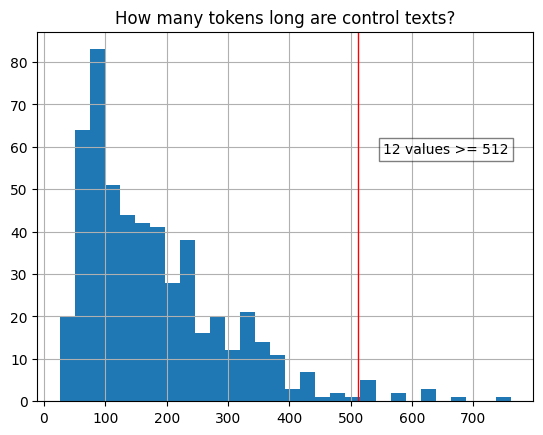

In [5]:
# How long are the texts? 
# BERT embeddings will truncate texts over 512 tokens. 

l = df['full_control_text'].apply(lambda x: len(x.split(' ')))
z = len([x for x in l if x >= 512])
print(f'Number of control texts longer than limit: {z}.')

ax = l.hist(bins=30)  # create histogram using axes object
ax.set_title('How many tokens long are control texts?')
plt.axvline(x=512, color='red', linewidth=1)
props = dict(boxstyle='square', facecolor='white', alpha=0.5)

ax.text(0.95, 0.7, f'{z} values >= 512', transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)
plt.show()

In [6]:
# create list for encoding
docs = list(df['full_control_text'].values)

# BERT base

- First we create embeddings using "bert-base-uncased", a popular model available on HuggingFace.
- Note that BERT will truncate any texts longer than 512 tokens.
- Feel free to play around with different models!

In [7]:
# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"  
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# function to do BERT embedding on text
def get_embedding(text):
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    output = model(**encoded_input)
    
    # Use the pooler output (representation of [CLS] token) and detach it to convert tensor to numpy
    embedding = output[1].detach().numpy()
    return embedding

In [8]:
# create embeddings for each row based on the text in column "full_control_text"
# this column has the "control category" and "control name" for additional context
df['BERTembeddings'] = df['full_control_text'].apply(get_embedding)

In [9]:
# transform embeddings from embedded list [[num, num]] to simple list [num, num]
df['BERTembeddings'] = df['BERTembeddings'].apply(lambda x: x[0])

In [10]:
# inspect
df.head(2)

,control_category,control_code,control_name,document,control_text_corrected,full_control_text,BERTembeddings
0,organisation of information security (ois),OIS-01,information security management system (isms),c5,Basic criterion: The cloud service provider operates an Information Security Management System (ISMS) in accordance with ISO/IEC 27001. The scope of the ISMS covers the cloud service provider's or...,Organisation of information security (ois). Information security management system (isms). Basic criterion: The cloud service provider operates an Information Security Management System (ISMS) in ...,"[-0.23476624, -0.22193538, -0.993742, 0.36702338, 0.8497383, -0.16401638, -0.63813585, -0.112916954, -0.9666923, -0.99915665, -0.7527641, 0.8858468, 0.11061413, 0.82643, -0.5260496, -0.41770625, -..."
1,organisation of information security (ois),OIS-02,information security policy,c5,"Basic criterion: The top management of the cloud service provider has adopted an information security policy and communicated it to internal and external employees, as well as cloud customers. The...",Organisation of information security (ois). Information security policy. Basic criterion: The top management of the cloud service provider has adopted an information security policy and communicat...,"[-0.6862502, -0.482106, -0.99791867, 0.66345596, 0.8985687, -0.33475596, 0.11295092, 0.24699804, -0.975181, -0.99998146, -0.7597701, 0.9544105, 0.7198171, 0.9297444, 0.13951182, -0.7354342, -0.127..."


# Embeddings from Finetuned Model

In [13]:
# Load finetuned BERT model and tokenizer locally
model_path = "../outputs/fine_tuned_model/"
model = BertModel.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

# function to do BERT embedding on text
def get_embedding(text):
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    output = model(**encoded_input)
    
    # Use the pooler output (representation of [CLS] token) and detach it to convert tensor to numpy
    embedding = output[1].detach().numpy()
    return embedding

In [14]:
# create embeddings for each row based on the text in column "full_control_text"
# this column has the "control category" and "control name" for additional context
df['finetuned_embeddings'] = df['full_control_text'].apply(get_embedding)

In [16]:
# transform embeddings from embedded list [[num, num]] to simple list [num, num]
df['finetuned_embeddings'] = df['finetuned_embeddings'].apply(lambda x: x[0])

# Savings results

In [20]:
# need to convert the embeddings so they're stored properly
# we convert the ndarray to a list, then serialize it to a JSON string
df['BERTembeddings'] = df['BERTembeddings'].apply(lambda x: json.dumps(x.tolist()))
df['finetuned_embeddings'] = df['finetuned_embeddings'].apply(lambda x: json.dumps(x.tolist()))


In [23]:
output_filename = "data-clean-embeddings.csv"
df.to_csv(f"../data/{output_filename}")